# Abstract

In this post, we investigate the phenomenon of double descent within the context of a corrupt image detection task. Our goal is to analyze how the performance of a supervised learning model changes as we vary the number of input features, particularly focusing on the relationship between model complexity and generalization error. Using a dataset where the objective is to classify whether images are corrupted or not, we track both training and testing mean squared error (MSE) across a range of feature counts. Our analysis reveals a clear double descent curve, with the test error initially decreasing, peaking near the interpolation threshold, and then decreasing again as the model becomes highly overparameterized. This behavior highlights the limitations of classical bias-variance intuition and showcases a modern perspective on model complexity.

# Considering p > n For Linear Regression

When the number of features $p$ exceeds the number of data observations $n$, the standard closed-form solution for linear regression becomes invalid due to an issue involving matrix invertibility. The formula $\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$ relies on the inversion of the matrix $\mathbf{X}^T\mathbf{X}$. However, when $p > n$, the matrix $\mathbf{X}$ has more columns than rows, making $\mathbf{X}^T\mathbf{X}$ a $p \times p$ matrix that is not full rank. This means it is singular, or rank-deficient, and therefore not invertible. As a result, the operation $(\mathbf{X}^T\mathbf{X})^{-1}$ is undefined, and the entire expression for $\hat{\mathbf{w}}$ in Equation 1 breaks down. This is why the closed-form solution is only valid when $n > p$, ensuring that $\mathbf{X}^T\mathbf{X}$ is invertible.


# Loading the Model and Packages

Source Code: https://raw.githubusercontent.com/Nibsquatch/Nibsquatch.github.io/refs/heads/main/OverparametrizedRegression.py

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from OverparametrizedRegression import MyLinearRegression, OverParameterizedLinearRegressionOptimizer
plt.style.use('seaborn-v0_8-whitegrid')

# Testing Model on Simple Data

In [2]:
# First we will define a class to generate random feature maps
def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X):
        return self.activation(X @ self.u + self.b)

To test our model we will fit nonlinear data using our random features class and feed these features to our LinearRegression model. We will then plot our predictions overtop the data.

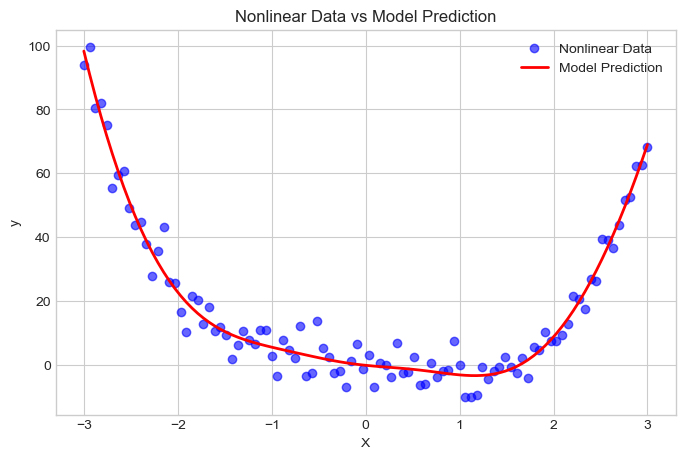

In [3]:
# Generate Nonlinear Data
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

# transorm our data
phi = RandomFeatures(n_features = 10)
phi.fit(X)
phi_X = phi.transform(X)

# instantiate our model and optimizer
LR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(LR)

# fit the model to our transformed data
opt.fit(phi_X, y)

# pull predictions from the data
y_pred = LR.predict(phi_X)

# Plot predictions vs actual data
plt.figure(figsize = (8, 5))
plt.scatter(X, y, label = 'Nonlinear Data', color = 'blue', alpha = 0.6)
plt.plot(X, y_pred, label = 'Model Prediction', color = 'red', linewidth = 2)
plt.title("Nonlinear Data vs Model Prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


Just based off preliminary predictions on training data is appears as if our overparametrized model is performing well. Lets continue on to explore how this model performs more in depth.

# Double Descent in Image Corruption Detection

To perform image corruption detections we will load a greyscale image of a flower and then replace some of the pixels with completely grey chunks to represent corruption of the image. We will then attempt to use our model to predict the number of corruptions in the image based on the image itself. Lets start by loading the image and corrupting it. 

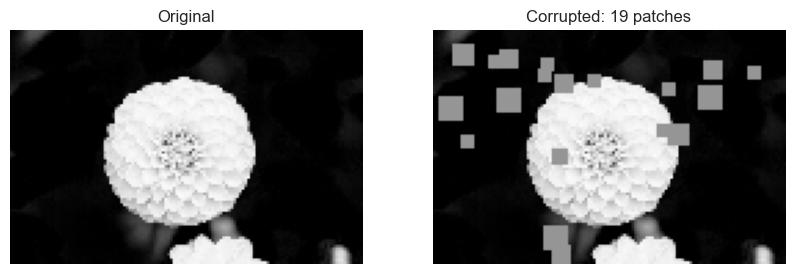

In [4]:
# load our flower image
dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

# define a function to corrupt the image
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

# use our function to load and corrupt the flower image and view the new image side by side with the natural image
X, y = corrupted_image(flower, mean_patches = 50)

# Show original and corrupted side by side
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(flower)  
ax[0].set_title("Original")
ax[0].axis("off")

ax[1].imshow(X, vmin = 0, vmax=1)  # Keep value range, don't force colormap
ax[1].set_title(f"Corrupted: {y} patches")
ax[1].axis("off")

plt.show()

Now that we have a method to generate corrupted flowers with varying levels of corruption, we will generate a dataset of 200 samples of corrupted images and split into testing and training data.

In [5]:
# set 200 samples as our benchmark dataset size
n_samples = 200

# generate 200 corrupted images
X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

# Reshape the images to lay them out into long rows
X = X.reshape(n_samples, -1)

# split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42)

Time to train on our model on our corrupt image dataset. As a baseline, lets see how a standard linear model would perform before overparameterization. We will then iterate through varying levels of overparametrization and keep track of the MSE for both training and testing. For our feature extension we will also used a squared activation instead of a sigmoid activation.

In [ ]:
# Initialize arrays to keep track of MSE and number of features
MSE_training, MSE_testing = [], []
num_features = []

# max features to use for our feature matrix and iteration
max_features = 1000

for i in range(1, max_features + 1):

    # generate our phi function
    phi = RandomFeatures(n_features = i, activation = square)
    
    # fit to both the training and testing data
    phi.fit(X_train)
    phi_X_train = phi.transform(X_train)

    phi.fit(X_test)
    phi_X_test = phi.transform(X_test)

    # instantiate and fit a linear regression model with an optimizer
    LR = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(LR)

    opt.fit(phi_X_train, y_train)

    # get the training MSE, testing MSE, and the number of features
    MSE_training.append(LR.loss(phi_X_train, y_train))
    MSE_testing.append(LR.loss(phi_X_test, y_test))
    num_features.append(len(LR.w))

Lets visualize how our training and testing MSE are changing as a result of increasing the number of features.

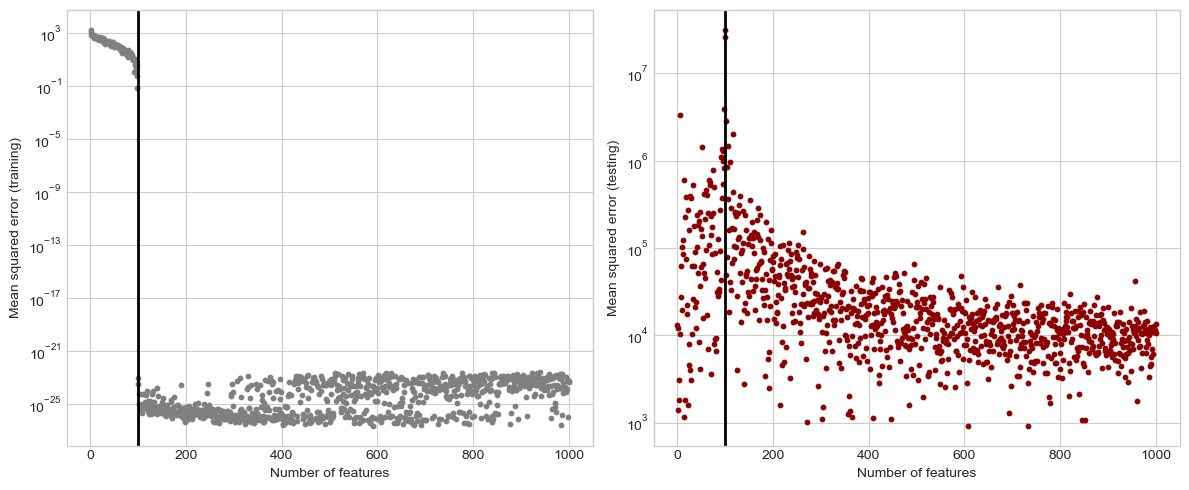

In [32]:
# Create plots
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# --- Training Plot ---
axes[0].scatter(num_features, MSE_training, color = 'gray', s = 10)
axes[0].axvline(100, color = "black", lw = 2)
axes[0].set_yscale('log')
axes[0].set_xlabel("Number of features")
axes[0].set_ylabel("Mean squared error (training)")

# --- Testing Plot ---
axes[1].scatter(num_features, MSE_testing, color = 'darkred', s = 10)
axes[1].axvline(100, color = "black", lw = 2)
axes[1].set_yscale('log')
axes[1].set_xlabel("Number of features")
axes[1].set_ylabel("Mean squared error (testing)")

plt.tight_layout()
plt.show()

The vertical black lines represent the iterpolation point, or the point where the number of features is equivalent to the number of samples. This is a typical marker for double descent, where as the number of features becomes greater than the number of samples the loss will begin to go back down. Our data demonstrates that this is clearly the case for image classification as the MSE increase dramatically until the interpolation threshold and then begins to gradually decrease; the MSE for the training data has seeminly high variance but because of the log scale it actually demonstrates effectively no loss. If we had more computing power available we could attempt to extend this model to 10,000 features as it seems as if the MSE for the testing data is still following a negative trend even around 1000 features.

In [39]:
# print the best number of features to produce the minimum MSE in the testing data
min_MSE = min(MSE_testing)
min_features = num_features[MSE_testing.index(min_MSE)]

print("The smallest testing MSE achieved was " + str(min_MSE.item()) + " which occured with " + str(min_features) + " features which occurs far beyond the interpolation point.")

The smallest testing MSE achieved was 917.8932718554004 which occured with 608 features which occurs far beyond the interpolation point.


# Discussion

Through our corrupt image detection experiment, we observed a distinct double descent pattern in model performance as the number of features increased. The training error decreased until the number of features reached the interpolation threshold, where the training error dropped to vitrually none, while the test error showed a notable spike at the interpolation threshold before steadily dropping again in the overparameterized regime. If we had access to more computing, future experiments should include increasing the number of features past the limits tested in this plog. These findings still support recent theoretical developments in machine learning that suggest overparameterized models can generalize well despite perfectly fitting the training data.